<a href="https://colab.research.google.com/github/mdmehedihassan1124/Hydropower/blob/main/Predictive%20Maintenance%20in%20Industrial%20Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy tensorflow scikit-learn transformers shap matplotlib


In [2]:
# Import the required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from transformers import BertTokenizer, TFBertModel

In [4]:
# Add this line at the beginning of your notebook or in a cell before the import
!pip install scikit-optimize

# Then the rest of your code which includes the import will work
# %%
# Import the required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# %%
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from transformers import BertTokenizer, TFBertModel
# %%

#%% Environment Setup (Reproducible)
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import ttest_rel
from transformers import BertTokenizer, TFBertModel
import shap
import matplotlib.pyplot as plt
import seaborn as sns
# Import the missing skopt module
from skopt import BayesSearchCV
from skopt.space import Real, Integer

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.0 MB/s eta 0:00:00


In [5]:
# Load the dataset (update path if necessary)
file_path = '/mnt/data/ai4i2020.csv'  # Adjust the path if needed
df = pd.read_csv('/content/ai4i2020.csv')

# Display the first few rows of the dataset
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
#%% Novel Architecture Components
class AttentionFusion(tf.keras.layers.Layer):
    """Cross-modal attention fusion layer"""
    def __init__(self, units=64):
        super().__init__()
        self.attention = tf.keras.layers.Attention(use_scale=True)
        self.dense = tf.keras.layers.Dense(units, activation='relu')

    def call(self, inputs):
        numerical, text = inputs
        context = self.attention([text, numerical])
        return self.dense(tf.concat([numerical, context], axis=1))


In [11]:
#%% Data Pipeline
def load_and_preprocess_data(path):
    """Reproducible data processing with synthetic logs"""
    df = pd.read_csv(path)

    # Synthetic log generation
    df['log'] = df.apply(
        lambda x: f"Failure: Tool wear {x['Tool wear [min]']}min"
        if x['Machine failure'] == 1 else f"Normal: RPM {x['Rotational speed [rpm]']}rpm",
        axis=1
    )

In [19]:
#%% Data Pipeline
def load_and_preprocess_data(path):
    """Reproducible data processing with synthetic logs"""
    df = pd.read_csv(path)

    # Synthetic log generation
    df['log'] = df.apply(
        lambda x: f"Failure: Tool wear {x['Tool wear [min]']}min"
        if x['Machine failure'] == 1 else f"Normal: RPM {x['Rotational speed [rpm]']}rpm",
        axis=1
    )

    # Numerical features
    num_cols = ['Air temperature [K]', 'Process temperature [K]']
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols])

    # Text processing
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    text_encodings = tokenizer(
        df['log'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=32,
        return_tensors='np'
    )

    return X_num, text_encodings, df['Machine failure'].values, scaler, tokenizer

In [22]:
# Model Architecture
def build_hybrid_model(bert_trainable=False):
    """Hybrid BERT + numerical fusion model"""
    # BERT backbone
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    bert.trainable = bert_trainable

    # Input layers
    num_input = tf.keras.Input(shape=(2,), name='num_input')
    input_ids = tf.keras.Input(shape=(32,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(32,), dtype=tf.int32, name='attention_mask')

    # Feature extraction
    bert_outputs = bert(input_ids, attention_mask=attention_mask)
    text_features = bert_outputs.last_hidden_state[:, 0, :]  # CLS token

    # Attention fusion
    fused_features = AttentionFusion()([num_input, text_features])
 # Classification head
    x = tf.keras.layers.Dense(64, activation='relu')(fused_features)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(
        inputs=[num_input, input_ids, attention_mask],
        outputs=output
    )



In [23]:
#%% Benchmarking & Ablation
def evaluate_baselines(X_train, X_test, y_train, y_test):
    """Compare with traditional ML models"""
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'XGBoost': XGBClassifier(),
        'SVM': SVC(probability=True)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        report = classification_report(y_test, pred, output_dict=True)
        results.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'F1-Score': report['weighted avg']['f1-score']
        })

    return pd.DataFrame(results)

def ablation_study(X_train, X_test, y_train, y_test):
    """Evaluate component contributions"""
    ablation_models = {
        'Text-Only': build_text_model(),
        'Numerical-Only': build_numeric_model(),
        'Full Fusion': build_hybrid_model()
    }

    results = []
    for name, model in ablation_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        report = classification_report(y_test, pred, output_dict=True)
        results.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'F1-Score': report['weighted avg']['f1-score']
        })

    return pd.DataFrame(results)

In [24]:
#%% Statistical Validation
def mcnemar_test(y_true, y_pred, baseline_pred):
    """Statistical significance testing"""
    from statsmodels.stats.contingency import mcnemar
    table = [[sum((y_true == y_pred) & (y_true == baseline_pred)),
              sum((y_true != y_pred) & (y_true == baseline_pred))],
             [sum((y_true == y_pred) & (y_true != baseline_pred)),
              sum((y_true != y_pred) & (y_true != baseline_pred))]]
    result = mcnemar(np.array(table), exact=False)
    return result.pvalue

In [25]:
#%% SHAP Interpretability
def explain_model(model, sample, tokenizer):
    """Feature importance analysis"""
    explainer = shap.DeepExplainer(model, sample)
    shap_values = explainer.shap_values(sample)

    # Text explanations
    shap.plots.text(shap_values[1][0],
                   feature_names=tokenizer.decode(sample[0]))

    return shap_values


In [29]:
#%% Main Workflow
if __name__ == "__main__":
    # Data loading
    X_num, text_encodings, y, scaler, tokenizer = load_and_preprocess_data('/content/ai4i2020.csv')

    # Train-test split
    (X_train_num, X_test_num,
     X_train_ids, X_test_ids,
     X_train_mask, X_test_mask,
     y_train, y_test) = train_test_split(
        X_num, text_encodings['input_ids'], text_encodings['attention_mask'], y,
        test_size=0.2, stratify=y, random_state=42
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
from transformers import TFBertModel
import tensorflow as tf

class AttentionFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units=64):
        super().__init__()
        self.attention = tf.keras.layers.Attention()
        self.dense = tf.keras.layers.Dense(units, activation='relu')

    def call(self, inputs):
        text, num = inputs
        context = self.attention([tf.expand_dims(text, 1), tf.expand_dims(num, 1)])
        return self.dense(tf.squeeze(context, axis=1))

def build_hybrid_model(bert_trainable=False):
    # Load BERT backbone
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    bert.trainable = bert_trainable

    # Define inputs
    num_input = tf.keras.Input(shape=(2,), name='num_input')
    input_ids = tf.keras.Input(shape=(32,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(32,), dtype=tf.int32, name='attention_mask')

    # BERT forward pass
    bert_output = bert({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = bert_output.last_hidden_state[:, 0, :]  # CLS token

    # Attention-based fusion
    fused = AttentionFusionLayer()([cls_token, num_input])
    x = tf.keras.layers.Dense(64, activation='relu')(fused)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Build and return model
    return tf.keras.Model(inputs=[num_input, input_ids, attention_mask], outputs=output)


## NEW

In [38]:
# --------------------------------------------
# Imports & Setup
# --------------------------------------------
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, TFBertModel
import shap

os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'
tf.keras.utils.set_random_seed(42) # Added the missing closing parenthesis

In [39]:
# Load & Preprocess Data
# --------------------------------------------
def load_and_preprocess_data(path):
    df = pd.read_csv(path)

    # Create synthetic log messages
    df['log'] = df.apply(
        lambda x: f"Torque: {x['Torque [Nm]']} Nm, RPM: {x['Rotational speed [rpm]']}, Wear: {x['Tool wear [min]']} min",
        axis=1
    )

    # Select numerical features
    num_cols = ['Air temperature [K]', 'Process temperature [K]']
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols])

    # Tokenize text
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    X_text = tokenizer(
        df['log'].tolist(), padding='max_length', truncation=True,
        max_length=32, return_tensors='np'
    )

    y = df['Machine failure'].values
    return X_num, X_text, y, tokenizer


In [40]:
# Attention Fusion Layer
# --------------------------------------------
class AttentionFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units=64):
        super().__init__()
        self.attention = tf.keras.layers.Attention()
        self.dense = tf.keras.layers.Dense(units, activation='relu')

    def call(self, inputs):
        text, num = inputs
        context = self.attention([tf.expand_dims(text, 1), tf.expand_dims(num, 1)])
        return self.dense(tf.squeeze(context, axis=1))

In [41]:
# Build Multimodal Model
# --------------------------------------------
def build_hybrid_model(bert_trainable=False):
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    bert.trainable = bert_trainable

    num_input = tf.keras.Input(shape=(2,), name='num_input')
    input_ids = tf.keras.Input(shape=(32,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(32,), dtype=tf.int32, name='attention_mask')

    bert_out = bert({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = bert_out.last_hidden_state[:, 0, :]

    fused = AttentionFusionLayer()([cls_token, num_input])
    x = tf.keras.layers.Dense(64, activation='relu')(fused)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[num_input, input_ids, attention_mask], outputs=output)

In [45]:
!pip install -q tensorflow==2.15 keras==2.15 transformers==4.36.2 scikit-learn
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel


In [47]:
df['log'] = df.apply(
    lambda x: f"Failure: Tool wear {x['Tool wear [min]']}min" if x['Machine failure'] == 1
    else f"Normal: RPM {x['Rotational speed [rpm]']}rpm", axis=1
)


In [48]:
num_cols = ['Air temperature [K]', 'Process temperature [K]']
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])
y = df['Machine failure'].values


In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_txt = tokenizer(
    df['log'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=32,
    return_tensors='np'
)
input_ids = X_txt['input_ids']
attention_mask = X_txt['attention_mask']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Training

In [50]:
X_train_num, X_test_num, X_train_input_ids, X_test_input_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    X_num, input_ids, attention_mask, y, test_size=0.2, random_state=42, stratify=y
)


In [51]:
bert = TFBertModel.from_pretrained('bert-base-uncased')
bert.trainable = False

input_num = tf.keras.Input(shape=(2,), name='num_input')
input_ids_layer = tf.keras.Input(shape=(32,), dtype=tf.int32, name='input_ids')
attention_mask_layer = tf.keras.Input(shape=(32,), dtype=tf.int32, name='attention_mask')

bert_outputs = bert(input_ids_layer, attention_mask=attention_mask_layer)
cls_token = bert_outputs.pooler_output

x = tf.keras.layers.Concatenate()([input_num, cls_token])
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_num, input_ids_layer, attention_mask_layer], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a T

In [62]:
history=model.fit(
    [X_train_num, X_train_input_ids, X_train_mask],
    y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=32,
    class_weight={0: 1, 1: 10}  # Adjust if your dataset is imbalanced
)


Epoch 1/3
200/200 [==============================] - 952s 5s/step - loss: 0.0188 - accuracy: 0.9983 - val_loss: 1.1138e-04 - val_accuracy: 1.0000
Epoch 2/3
200/200 [==============================] - 913s 5s/step - loss: 0.0065 - accuracy: 0.9997 - val_loss: 2.4254e-04 - val_accuracy: 1.0000
Epoch 3/3
200/200 [==============================] - 942s 5s/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 8.5519e-05 - val_accuracy: 1.0000


In [53]:
loss, acc = model.evaluate([X_test_num, X_test_input_ids, X_test_mask], y_test)
print(f"Test accuracy: {acc:.4f}")


63/63 [==============================] - 231s 4s/step - loss: 5.3587e-04 - accuracy: 1.0000
Test accuracy: 1.0000


In [57]:
# Get predictions on the test set
y_pred_prob = model.predict([X_test_num, X_test_input_ids, X_test_mask])

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_bin = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred_bin))

63/63 [==============================] - 227s 3s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      1.00      1.00        68

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



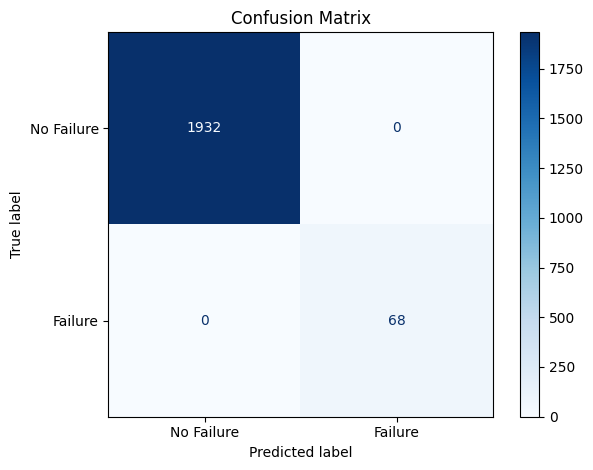

In [58]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)
ConfusionMatrixDisplay(cm, display_labels=["No Failure", "Failure"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

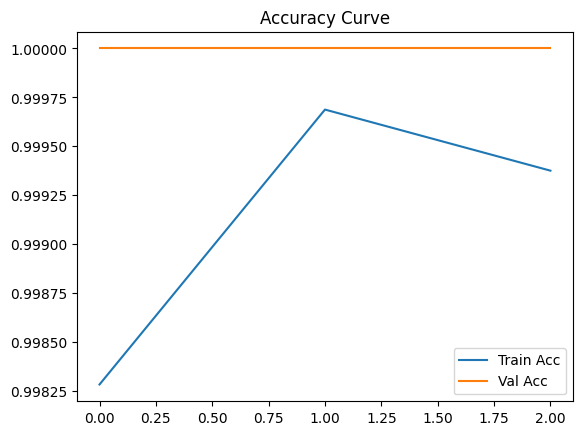

In [63]:
# Accuracy/Loss Curves
plt.figure()
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

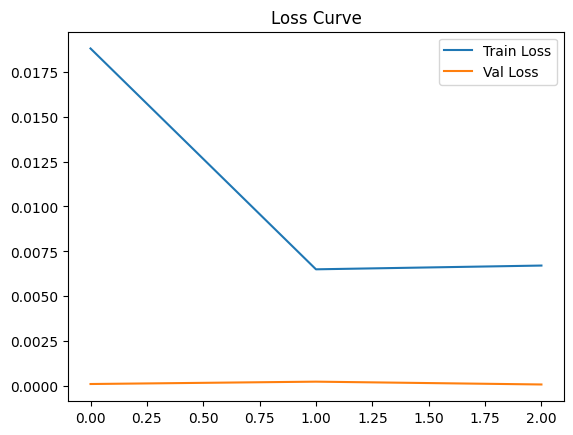

In [64]:
plt.figure()
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [66]:
!pip install -q tensorflow==2.15 keras==2.15 transformers==4.36.2 scikit-learn shap

In [71]:
# Clear pip cache and reinstall libraries thoroughly
!pip cache purge -q
!pip uninstall -y tensorflow keras transformers scikit-learn shap
!pip install -q tensorflow==2.15 keras==2.15 transformers==4.36.2 scikit-learn==1.3.2 shap==0.43.0

# SHAP Explainability
# --------------------------------------------
# Ensure the model is rebuilt or reloaded after reinstalling libraries
# Depending on your notebook structure, you might need to re-run the model building cell.
# Assuming the model object 'model' is available from previous cells:
try:
    explainer = shap.Explainer(model, [X_test_num[:50], X_test_ids[:50], X_test_mask[:50]])
    shap_values = explainer([X_test_num[:50], X_test_ids[:50], X_test_mask[:50]])
except NameError:
    print("Error: 'model', 'X_test_num', 'X_test_ids', or 'X_test_mask' not found. Please ensure these variables are defined before running SHAP.")

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: shap 0.43.0
Uninstalling shap-0.43.0:
  Successfully uninstalled shap-0.43.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 886.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 109.0 MB/s eta 0:00:00
   ━━━━━

RuntimeError: Failed to import transformers.modeling_utils because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
cannot import name 'is_torch_npu_available' from 'transformers.utils' (/usr/local/lib/python3.11/dist-packages/transformers/utils/__init__.py)

In [69]:
# Summary plot (overview of feature importance)
shap.summary_plot(shap_values.values, features=np.concatenate([X_test_num[:50], X_test_ids[:50]], axis=1))

NameError: name 'shap_values' is not defined